In [15]:
%matplotlib inline

In [16]:
import argparse
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial.distance
import seaborn as sns
import pandas as pd

import torch
import cpc.feature_loader as fl
import cpc.train as tr
from cpc.dataset import AudioBatchData, findAllSeqs, filterSeqs, parseSeqLabels
import torch.nn.functional as F
from cpc.criterion.seq_alignment import collapseLabelChain

In [17]:
sys.path.append(os.path.dirname(tr.__file__))

In [18]:
onEncodings = True
# CP = '/pio/scratch/1/i323106/wav2vec/runs/cpc/zelasko-buck+ls/checkpoint_49.pt'
CP = '/pio/scratch/1/i323106/wav2vec/runs/cpc/acpc-baseline-cosine/checkpoint_49.pt'

In [19]:
class BaseCriterion(torch.nn.Module):
    def warmUp(self):
        return False

    def update(self):
        return

class CTCPhoneCriterion(BaseCriterion):

    def __init__(self, dimEncoder, nPhones, onEncoder, useLSTM=True, forbid_blank=True, convClassifier=False,
                bidirectional=False):

        super(CTCPhoneCriterion, self).__init__()
        self.useLSTM = useLSTM
        self.convClassifier = convClassifier
        self.PhoneCriterionClassifier = torch.nn.Linear(dimEncoder, nPhones + 1)
        if useLSTM:
            self.lstm = torch.nn.LSTM(dimEncoder, dimEncoder, num_layers=1, batch_first=True, bidirectional=bidirectional)
            d = 2 if bidirectional else 1
            if convClassifier:
                self.PhoneCriterionClassifier = torch.nn.Conv1d(
                d * dimEncoder, nPhones + 1, 8, stride=4)
            else:
                self.PhoneCriterionClassifier = torch.nn.Sequential(
                    torch.nn.Linear(dimEncoder, dimEncoder),
                    torch.nn.ReLU(),
                    torch.nn.Linear(dimEncoder, nPhones + 1),
                )
        self.lossCriterion = torch.nn.CTCLoss(blank=nPhones, zero_infinity=True)
        self.onEncoder = onEncoder
        self.BLANK_LABEL = nPhones
        self.forbid_blank = forbid_blank

    def extra_repr(self):
        return f"CTCPhoneCriterion(..., onEncoder={self.onEncoder}, forbid_blank={self.forbid_blank})"

    def getPrediction(self, cFeature):
        B, S, H = cFeature.size()
        if not self.useLSTM:
            cFeature = cFeature.contiguous().view(B*S, H)
            return self.PhoneCriterionClassifier(cFeature).view(B, S, -1), None
        else:
            seqStates = self.lstm(cFeature)[0]
            if self.convClassifier:
                x = seqStates.permute(0, 2, 1)
                x = self.PhoneCriterionClassifier(x)
                return x.permute(0, 2, 1), seqStates
            else:
                x = self.PhoneCriterionClassifier(seqStates)
                return x, seqStates

    def forward(self, cFeature, otherEncoded, label):
        if isinstance(cFeature, dict):  # Second head uses smart pooling, therefore variable seqLens
            targetSizePred = cFeature['seqLens']
            cFeature = cFeature['states']
            B, _, H = cFeature.size()
        else:
            B, S, H = cFeature.size()
            targetSizePred = torch.ones(B, dtype=torch.int64,
                                    device=cFeature.device) * S
        if self.convClassifier:
            targetSizePred = ((targetSizePred - 8) // 4 + 1)

        if self.onEncoder:
            predictions, seqStates = self.getPrediction(otherEncoded)
        else:
            predictions, seqStates = self.getPrediction(cFeature)
        if self.forbid_blank:
            predictions += (
                -1e4 * 
                (torch.arange(self.BLANK_LABEL+1, device=predictions.device) == self.BLANK_LABEL
                ).float().view(1, 1, self.BLANK_LABEL+1))
        predictions = torch.nn.functional.log_softmax(predictions, dim=2)
        label = label.to(predictions.device)
        label, sizeLabels = collapseLabelChain(label)   
        return predictions, label, targetSizePred, sizeLabels

In [20]:
cdata = fl.getCheckpointData(os.path.dirname(CP))
_, _, args = cdata
model, args.hiddenGar, args.hiddenEncoder = fl.loadModel([CP])
assert args.speakerEmbedding == 0

try:
    criterion = tr.loadCriterion(CP, model.gEncoder.DOWNSAMPLING, len(speakers), None)
except:
    criterion = None
    print("Failed to load criterion :(((())))")

Loading checkpoint /pio/scratch/1/i323106/wav2vec/runs/cpc/acpc-baseline-cosine/checkpoint_49.pt
LocArgs: Namespace(CPCCTC=True, CPCCTCLearnBlank=False, CPCCTCLossTemp=1.0, CPCCTCMasq='', CPCCTCNoNegsMatchWin=False, CPCCTCNormalizeEncs=False, CPCCTCNormalizePreds=False, CPCCTCNumLevels=1, CPCCTCNumMatched=12, CPCCTCReductionFactor=4, CPCCTCSelfLoop=False, CPCCTCSkipBeg=0, CPCCTCSkipEnd=0, CTC=False, CTCphones=False, NoARonRegHead=False, abspos=False, arMode='LSTM', batchSizeGPU=32, beta1=0.9, beta2=0.999, captureCPCCTCalign=False, captureCPCCTClogScores=False, captureConvRepr=False, captureCtxRepr=False, captureDSfreq=None, captureDStotNr=None, captureEachEpochs=10, captureEverything=False, capturePhoneAlign=False, capturePred=False, captureSetStats=None, captureSpeakerAlign=False, cpc_mode=None, debug=False, dropout=True, encodeSegments=False, encoder_type='cpc', epsilon=1e-08, file_extension='.flac', gru_level=-1, headWeights=[1.0, 1.0], hiddenEncoder=256, hiddenGar=256, ignore_cache

In [21]:
args.pathDB = ['/pio/gluster/data/ls-train-clean-100/LibriSpeech/train-clean-100']
args.pathTrain = ['/pio/gluster/data/ls-train-clean-100/train_split.txt']
args.pathVal = ['/pio/gluster/data/ls-train-clean-100/test_split.txt']
args.pathPhone = '/pio/gluster/data/ls-train-clean-100/converted_aligned_phones.txt'
args.size_window = 20480
args.file_extension = ['.flac']
args.ignore_cache = True

seqNames, speakers = findAllSeqs(args.pathDB,
                                 extension=args.file_extension,
                                 loadCache=not args.ignore_cache)
phone_labels, n_phones = parseSeqLabels(args.pathPhone)

seq_val = filterSeqs(args.pathVal, seqNames)
db_val = AudioBatchData(args.pathDB, args.size_window, seq_val,
                        phone_labels, len(speakers))


837it [00:02, 294.06it/s]


Ran in an error while saving /pio/gluster/data/ls-train-clean-100/LibriSpeech/train-clean-100/_seqs_cache.txt: [Errno 13] Permission denied: '/pio/gluster/data/ls-train-clean-100/LibriSpeech/train-clean-100/_seqs_cache.txt'
Checking length...


5708it [00:00, 1909786.79it/s]


Done, elapsed: 2.847 seconds
Scanned 5708 sequences in 2.85 seconds
1 chunks computed
Joining pool
Joined process, elapsed=78.122 secs


In [22]:
criterion = CTCPhoneCriterion(model.gEncoder.dimEncoded, n_phones, True, useLSTM=True, convClassifier=True, bidirectional=True)
criterionCP = '/pio/scratch/1/i323106/wav2vec/runs/cpc/acpc-baseline-cosine/lineval_ctc_noblank_onenc_11layers_49/checkpoint_9.pt'
state_dict = torch.load(criterionCP, 'cpu')
criterion.load_state_dict(state_dict["cpcCriterion"])
criterion.cpu()

valLoader = db_val.getDataLoader(1, 'sequential', False, numWorkers=0)
confusionMatrix = np.zeros((n_phones + 1, n_phones + 1))

for batchData, label in valLoader:
    label = label['phone']
    with torch.no_grad():
        cFeature, encodedData, _ = model(batchData, None)
    ctcLogProbs, ctcLabel, targetSizePred, sizeLabels = criterion(cFeature[0], encodedData, label)
    ctcLogProbs = ctcLogProbs.permute(1, 0, 2)
    ctcLogProbs = ctcLogProbs.detach().requires_grad_()
    with torch.enable_grad():
        losses = F.ctc_loss(
            ctcLogProbs, 
            ctcLabel,
            targetSizePred,
            sizeLabels,
            reduction='none')
        losses.sum().backward()
        grads = ctcLogProbs.grad.detach()
        _, alignment = grads.min(-1)
        alignment = alignment.T
        predictedAlignment = ctcLogProbs.max(-1)[1].T
        pairs = torch.cat((alignment, predictedAlignment), dim=0).T
        for i, j in pairs:
            confusionMatrix[i, j] += 1
confusionMatrix = confusionMatrix[:-1, :-1]
confusionMatrix = (confusionMatrix / (np.sum(confusionMatrix, axis=1, keepdims=True) + 1e-6)) * 100

<AxesSubplot:>

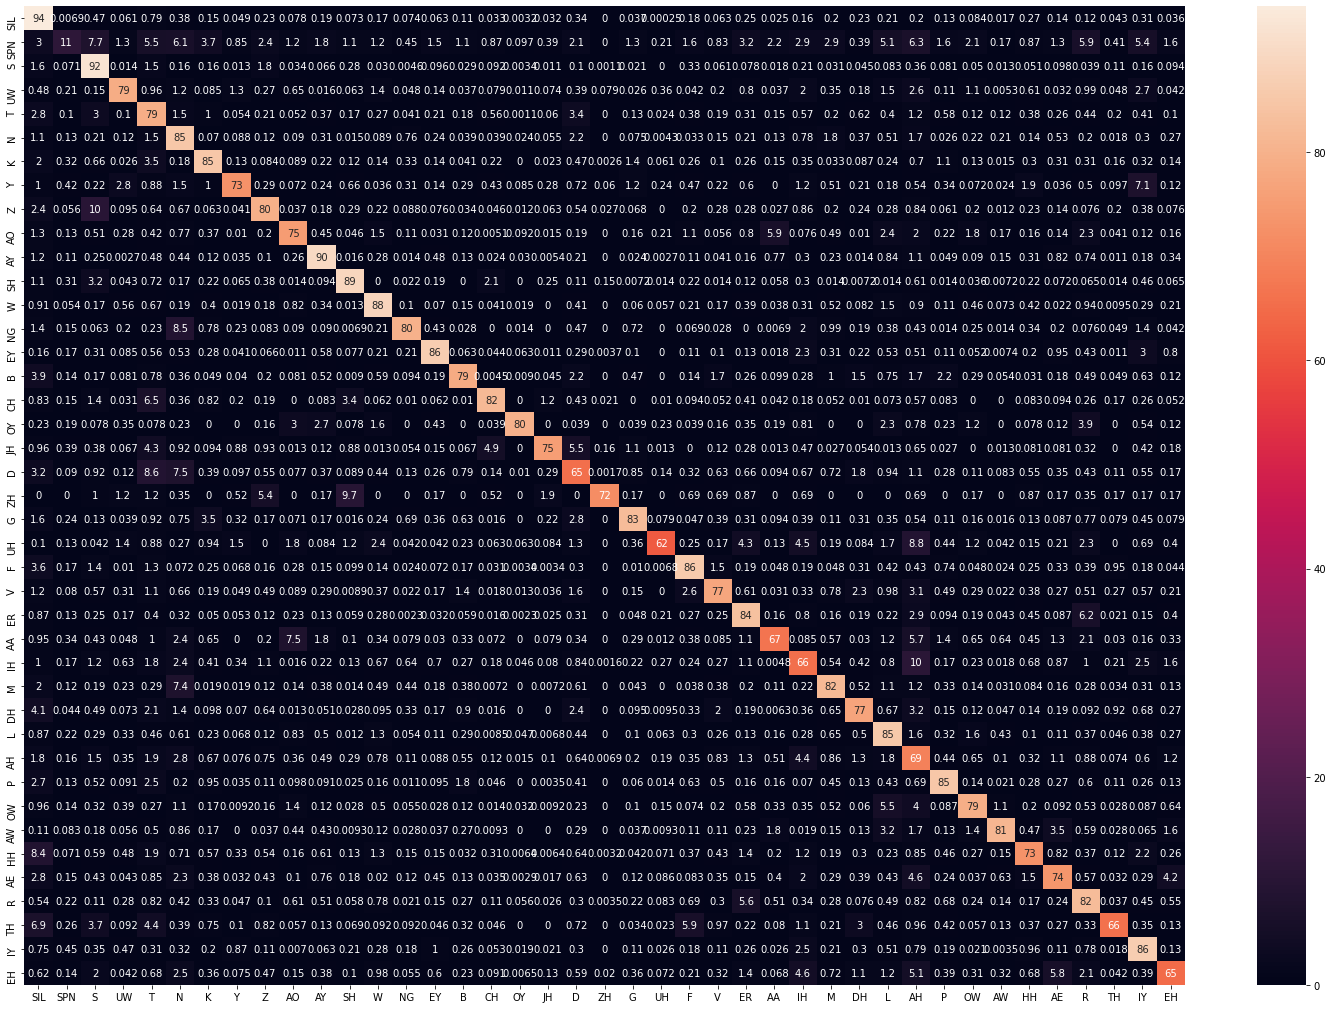

In [26]:
phoneNames = [
    'SIL','SPN','S','UW','T','N','K','Y','Z','AO','AY','SH','W','NG','EY',
    'B','CH','OY','JH','D','ZH','G','UH','F','V','ER','AA','IH',
    'M','DH','L','AH','P','OW','AW','HH','AE','R','TH','IY','EH'
]

dfCM = pd.DataFrame(confusionMatrix, index = phoneNames, columns = phoneNames)
plt.figure(figsize = (26, 18))
sns.heatmap(dfCM, annot=True)